In [5]:
import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff
from python_scripts import csv_processing as dp
#import dtreeviz as dt
import warnings
warnings.filterwarnings("ignore")

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, f1_score, recall_score, \
        confusion_matrix, classification_report, precision_score
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.utils.class_weight import compute_class_weight

In [19]:
df = pd.read_csv("../data/3year.csv")
X,y=dp.df_null_removal(df)
#concatenating the features and target variable
df = pd.concat([X, y], axis=1)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [27]:
len(y)
#X.shape

10501

In [23]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import pearsonr

# Assume X and y are already defined and cleaned as per previous steps

def information_gain(X, y):
    mi_scores = mutual_info_classif(X, y, discrete_features='auto')
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def correlation_selection(X, y):
    if isinstance(y, pd.Series):
        y = y.to_frame(name='Target')
    elif isinstance(y, pd.DataFrame):
        y.columns = ['Target'] 
    # Proper concatenation of X and y into a single DataFrame
    df_combined = pd.concat([X, y], axis=1)
    # Calculate the correlation matrix from the combined DataFrame
    correlation_matrix = df_combined.corr()
    # Extract correlations of all features with the target, excluding self-correlation
    correlation_w_target = correlation_matrix['Target'].drop('Target')
    # Return the absolute values of correlations, sorted by magnitude
    return correlation_w_target.abs().sort_values(ascending=False)

# Assuming X and y are already prepared and valid for feature selection
mi_scores = information_gain(X, y)
correlation_scores = correlation_selection(X, y)

print("Information Gain Scores:")
print(mi_scores)
print("\nCorrelation Scores:")
print(correlation_scores)


Information Gain Scores:
Attr27    0.019999
Attr24    0.014509
Attr13    0.013335
Attr26    0.012688
Attr46    0.012267
            ...   
Attr59    0.000308
Attr43    0.000000
Attr60    0.000000
Attr20    0.000000
Attr64    0.000000
Name: MI Scores, Length: 63, dtype: float64

Correlation Scores:
Attr35    0.044140
Attr22    0.039821
Attr25    0.036911
Attr10    0.035734
Attr2     0.035545
            ...   
Attr9     0.001237
Attr64    0.000646
Attr39    0.000604
Attr59    0.000418
Attr32    0.000341
Name: Target, Length: 63, dtype: float64


In [29]:
X.shape

(10501, 63)

In [33]:
from sklearn.metrics import make_scorer, f1_score, recall_score

def plot_feature_performance(X, y, score_series, max_features=None):
    # Ensure X and y have the same length
    if len(X) != len(y):
        raise ValueError("Mismatch in the number of rows between X and y.")

    f1_results = []
    recall_results = []
    feature_counts = []

    if not max_features:
        max_features = len(score_series)
    
    for i in range(1, max_features + 1):
        top_features = score_series.nlargest(i).index
        X_selected = X[top_features]
        # Cross-validation to evaluate model performance
        model = BalancedRandomForestClassifier(
                n_estimators=100,
                max_features='sqrt',
                min_samples_leaf=4,
                min_samples_split=10,
                max_depth=25,  
                class_weight={0:0.7, 1:0.32},
                bootstrap=True,
                min_impurity_decrease=0.00001,
                random_state=42
            )
        # Calculate F1-score and recall
        f1 = cross_val_score(model, X_selected, y, cv=5, scoring='f1')
        recall = cross_val_score(model, X_selected, y, cv=5, scoring='recall')
        
        f1_results.append(f1.mean())
        recall_results.append(recall.mean())
        feature_counts.append(i)

    # Plotting the F1-score results
    plt.figure(figsize=(10, 6))
    plt.plot(feature_counts, f1_results, marker='o', linestyle='-', markersize=8, label='F1 Score')
    plt.plot(feature_counts, recall_results, marker='o', linestyle='-', markersize=8, label='Recall')
    plt.xlabel('Number of Features')
    plt.ylabel('Score')
    plt.title('Model Performance vs. Number of Features')
    plt.legend()
    plt.grid(True)
    plt.show()


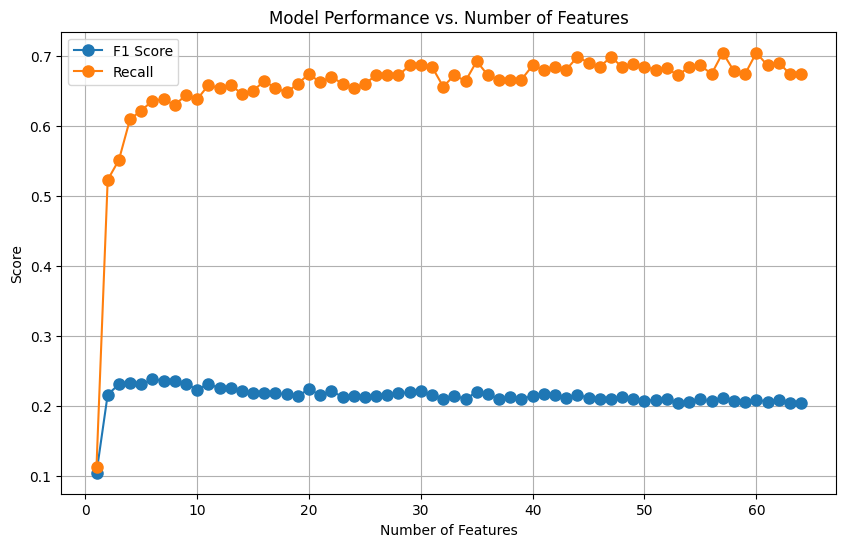

In [36]:
plot_feature_performance(X, y, mi_scores, max_features=64)

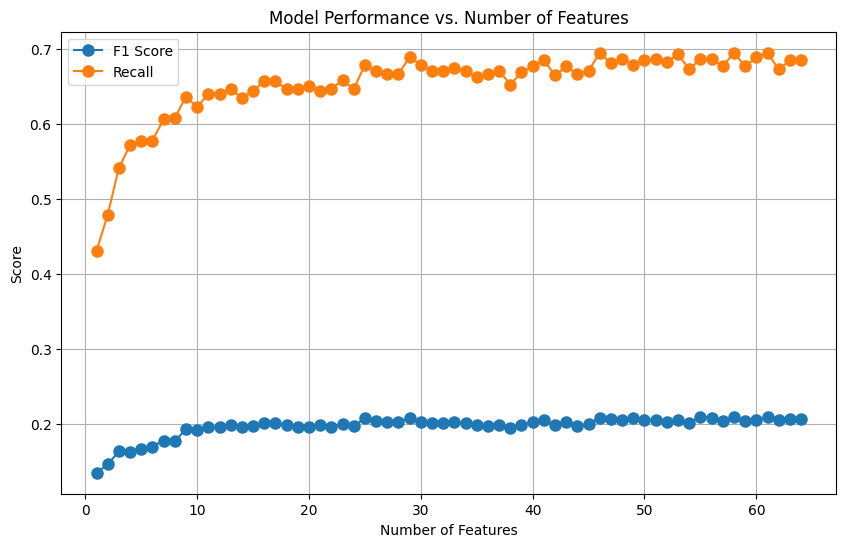

In [37]:
plot_feature_performance(X, y, correlation_scores, max_features=64)

In [133]:
from imblearn.over_sampling import SMOTE
# Hypothetical number of features to select
optimal_num_features = 13

# Select the top features based on the optimal number
top_features_mi = mi_scores.nlargest(optimal_num_features).index
top_features_corr = correlation_scores.nlargest(optimal_num_features).index

# If you want to consider the union of both methods:
selected_features_union = top_features_mi.union(top_features_corr)

# If you prefer to take the intersection (i.e., features deemed important by both methods):
selected_features_intersection = top_features_mi.intersection(top_features_corr)
print(len(selected_features_union))

# Now, use the selected feature set to train your final model.
# Example with the union of features:
X_selected = X[selected_features_union]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

# Select only the features that we have determined to be optimal
# Initialize the BalancedRandomForestClassifier with the selected features
brf_selected = BalancedRandomForestClassifier(
    n_estimators=80,
    max_features=None,
    min_samples_leaf=4,
    min_samples_split=2,
    max_depth=20,  
    class_weight={0:7, 1:2.8},
    bootstrap=True,
    random_state=42,
    ccp_alpha=0.00014,
    max_samples=0.2,
    oob_score=True,
    criterion='gini'
)

# Train the model on the training set
brf_selected.fit(X_train, y_train)

# Make predictions on the testing set
y_pred_selected = brf_selected.predict(X_test)

# Calculate evaluation metrics
accuracy_selected = accuracy_score(y_test, y_pred_selected)
f1_selected = f1_score(y_test, y_pred_selected)
recall_selected = recall_score(y_test, y_pred_selected)
conf_matrix_selected = confusion_matrix(y_test, y_pred_selected)
class_report_selected = classification_report(y_test, y_pred_selected)
train_accuracy = brf_selected.score(X_train, y_train)

# Print the evaluation metrics
print(f"Train Accuracy with selected features: {train_accuracy}")
print(f"Accuracy with selected features: {accuracy_selected}")
print(f"F1 Score with selected features: {f1_selected}")
print(f"Recall Score with selected features: {recall_selected}")
print(f"Confusion Matrix with selected features:\n{conf_matrix_selected}")
print(f"Classification Report with selected features:\n{class_report_selected}")


22
Train Accuracy with selected features: 0.8013095238095238
Accuracy with selected features: 0.7734412184673964
F1 Score with selected features: 0.24921135646687698
Recall Score with selected features: 0.797979797979798
Confusion Matrix with selected features:
[[1546  456]
 [  20   79]]
Classification Report with selected features:
              precision    recall  f1-score   support

           0       0.99      0.77      0.87      2002
           1       0.15      0.80      0.25        99

    accuracy                           0.77      2101
   macro avg       0.57      0.79      0.56      2101
weighted avg       0.95      0.77      0.84      2101



In [100]:
from sklearn.tree import DecisionTreeClassifier

# Train a decision tree classifier to get the ccp_alphas
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)  # Make sure X_train and y_train are defined and preprocessed

path = tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Now you can loop over the ccp_alphas as in your previous code


f1_scores = []

for ccp_alpha in ccp_alphas:
    model = RandomForestClassifier(random_state=42, ccp_alpha=ccp_alpha, n_estimators=100)
    f1 = cross_val_score(model, X_train, y_train, cv=5, scoring='f1').mean()
    f1_scores.append(f1)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas[:-1], f1_scores[:-1], marker='o', drawstyle="steps-post")  # exclude the last point (total tree pruning)
plt.xlabel('ccp_alpha')
plt.ylabel('Average F1 Score')
plt.title('F1 Score vs ccp_alpha')
plt.show()

KeyboardInterrupt: 

In [65]:
X_train_smote, y_train_smote = SMOTE(random_state=42).fit_resample(X_train, y_train)

rdt= RandomForestClassifier(
    n_estimators=100,
    max_features='sqrt',
    min_samples_leaf=4,
    min_samples_split=10,
    max_depth=25,  
    class_weight={0:0.7,1:0.32},
    bootstrap=False,
    min_impurity_decrease=0.00001,
    random_state=42,
    ccp_alpha=0.00016
)

# Train the model on the training set
rdt.fit(X_train_smote, y_train_smote)

# Make predictions on the testing set
y_pred_selected = rdt.predict(X_test)

# Calculate evaluation metrics
accuracy_selected = accuracy_score(y_test, y_pred_selected)
f1_selected = f1_score(y_test, y_pred_selected)
recall_selected = recall_score(y_test, y_pred_selected)
conf_matrix_selected = confusion_matrix(y_test, y_pred_selected)
class_report_selected = classification_report(y_test, y_pred_selected)
train_accuracy = rdt.score(X_train, y_train)

# Print the evaluation metrics
print(f"Train Accuracy with selected features: {train_accuracy}")
print(f"Accuracy with selected features: {accuracy_selected}")
print(f"F1 Score with selected features: {f1_selected}")
print(f"Recall Score with selected features: {recall_selected}")
print(f"Confusion Matrix with selected features:\n{conf_matrix_selected}")
print(f"Classification Report with selected features:\n{class_report_selected}")

Train Accuracy with selected features: 0.9923809523809524
Accuracy with selected features: 0.9190733100602984
F1 Score with selected features: 0.25219941348973607
Recall Score with selected features: 0.2905405405405405
Confusion Matrix with selected features:
[[2853  150]
 [ 105   43]]
Classification Report with selected features:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      3003
           1       0.22      0.29      0.25       148

    accuracy                           0.92      3151
   macro avg       0.59      0.62      0.60      3151
weighted avg       0.93      0.92      0.92      3151

